<a href="https://colab.research.google.com/github/CaedinM/primary-election-analysis/blob/main/DATA102_Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
!pip install thefuzz[speedup]
from thefuzz import process
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# EDA Section

## Quantitative Variable 1 -- Funding Received


In [ ]:
#load dataset
senate_funding = pd.read_csv('senate_funding.csv')
house_funding = pd.read_csv('house_funding.csv')
funding = pd.concat([senate_funding, house_funding], ignore_index=True)

In [ ]:
#mean and median campaign funding
funding_mean = funding['disbursements'].mean()
funding_median = funding['disbursements'].median()

print(f"Mean Campaign Funding: {funding_mean}")
print(f"Median Campaign Funding: {funding_median}")

Mean Campaign Funding: 814993.8646318607
Median Campaign Funding: 7359.9349999999995


In [ ]:
#remove outliers
lower = funding['disbursements'].quantile(0.025)
upper = funding['disbursements'].quantile(0.975)
funding_no_outliers = funding[(funding['disbursements'] > lower) & (funding['disbursements'] < upper)]

funding_no_outliers_mean = funding_no_outliers['disbursements'].mean()
funding_no_outliers_median = funding_no_outliers['disbursements'].median()

print(f"Mean Campaign Funding (No Outliers): {funding_no_outliers_mean}")
print(f"Median Campaign Funding (No Outliers): {funding_no_outliers_median}")

Mean Campaign Funding (No Outliers): 638936.6117131148
Median Campaign Funding (No Outliers): 116093.05


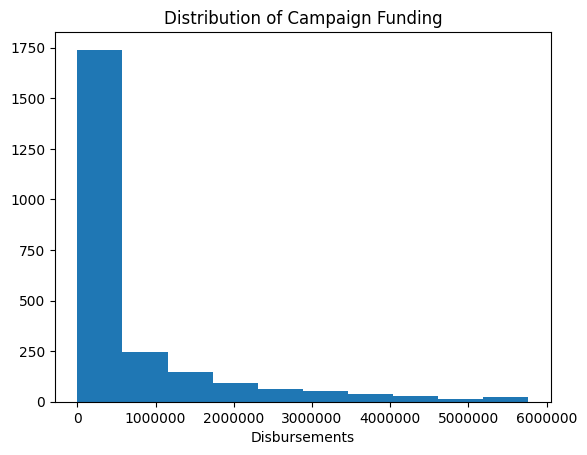

In [ ]:
#distribution of campaign funding
plt.hist(funding_no_outliers['disbursements'], bins=10)
plt.title('Distribution of Campaign Funding')
plt.xlabel('Disbursements')
plt.ticklabel_format(style='plain', axis='x')

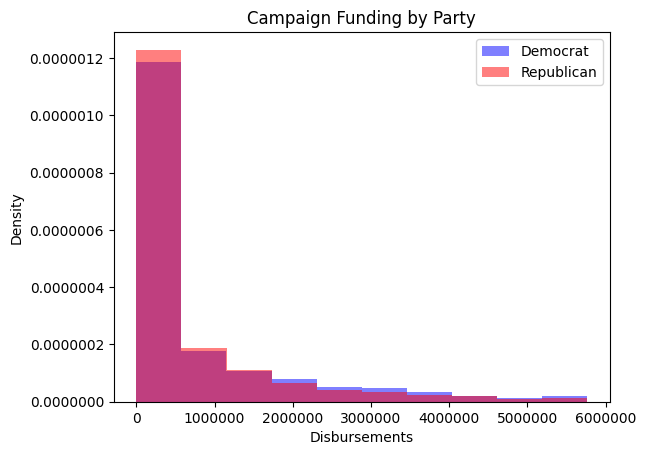

In [ ]:
#visualize campaign funding by party
dem_funding = funding_no_outliers[funding_no_outliers['party'] == 'DEM']['disbursements']
rep_funding = funding_no_outliers[funding_no_outliers['party'] == 'REP']['disbursements']

plt.hist(dem_funding, bins=10, alpha=0.5, label='Democrat', color='blue', density='True')
plt.hist(rep_funding, bins=10, alpha=0.5, label='Republican', color='red', density='True')

plt.title('Campaign Funding by Party')
plt.xlabel('Disbursements')
plt.ylabel('Density')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

Democrats tend to have higher-funded campaigns than Republicans. This means that party could be a confounding variable.

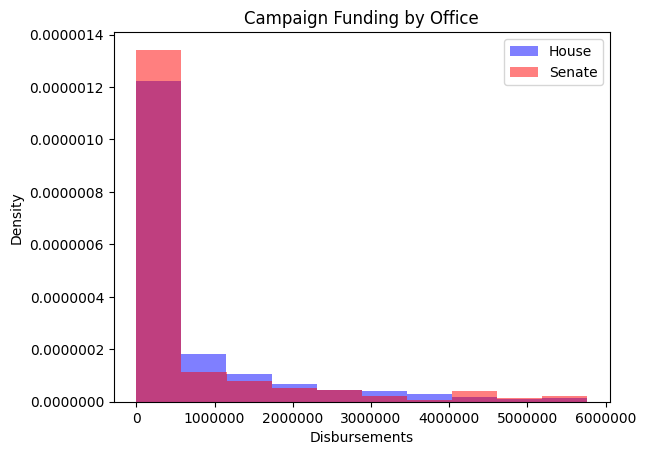

In [ ]:
#visualize campaign funding by house and senate
senate_funding_no_outliers = funding_no_outliers[funding_no_outliers['office'] == 'S']['disbursements']
house_funding_no_outliers = funding_no_outliers[funding_no_outliers['office'] == 'H']['disbursements']

plt.hist(house_funding_no_outliers, bins=10, alpha=0.5, label='House', color='blue', density='True')
plt.hist(senate_funding_no_outliers, bins=10, alpha=0.5, label='Senate', color='red', density='True')

plt.title('Campaign Funding by Office')
plt.xlabel('Disbursements')
plt.ylabel('Density')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

Senate campaigns tend to be either very high-funded, or very low-funded.

In [ ]:
#average campaign funding by state
state_funding = funding.groupby('state')['disbursements'].mean().reset_index()
state_funding['avg disbursements'] = state_funding['disbursements'].round(2)
state_funding = state_funding.sort_values(by='avg disbursements', ascending=False)[['state', 'avg disbursements']]

fig = px.choropleth(
    state_funding,
    locations='state',
    locationmode='USA-states',
    color='avg disbursements',
    color_continuous_scale='Viridis',
    scope='usa',
    labels={'avg_disbursements': 'Avg Disbursements'},
    title='Average Campaign Funding by State'
)

fig.update_layout(
    geo=dict(showlakes=True, lakecolor='lightblue'),
    margin=dict(l=0, r=0, t=30, b=0)
)

fig.show()

Swing states have higher campaign funding, on average. This means that state could be another confounding variable.

## Quantitative Variable 2 -- WAR results

In [ ]:
war_df = pd.read_csv("WAR.csv")
war_df.head()

,Year,Chamber,Geography,Democrat,Republican,WAR,Sortable
0,2024,House,AL-01,Tom Holmes,Barry Moore,D+1.3,-1.30
1,2024,House,AL-02,Shomari Figures,Caroleene Dobson,D+2.2,-2.17
2,2024,House,AL-06,Elizabeth Anderson,Gary Palmer,D+4.5,-4.47
3,2024,House,AL-07,Terri Sewell,Robin Litaker,R+0.2,0.15
4,2024,House,AK-AL,Mary Peltola,Nick Begich,D+9.1,-9.13


In [ ]:
## Filter for 2022
## Create column for party that won
## Create column for full state name

# war_df.shape
war_df["outcome"] = np.abs(war_df["Sortable"])
war_df["Party Winner"] = war_df["Sortable"].apply(lambda x: "Democrat" if x < 0 else "Republican")

us_state_abbrev = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
    "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas",
    "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
    "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York",
    "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah",
    "VT": "Vermont", "VA": "Virginia", "WA": "Washington", "WV": "West Virginia",
    "WI": "Wisconsin", "WY": "Wyoming", "DC": "District of Columbia"
}

state_names_set = set(us_state_abbrev.values())

def extract_state(name):
    if name in state_names_set:
        return name
    abbrev = name[:2]
    return us_state_abbrev.get(abbrev, name)

war_df["State"] = war_df["Geography"].apply(extract_state)
state_name_to_abbrev = {v: k for k, v in us_state_abbrev.items()}
war_df["State Abv"] = war_df["State"].map(state_name_to_abbrev)

war_df_2022 = war_df[war_df["Year"] == 2022]
war_df_2022

,Year,Chamber,Geography,Democrat,Republican,WAR,Sortable,outcome,Party Winner,State,State Abv
432,2022,House,AK-AL,Mary Peltola,Sarah Palin,D+19.4,-19.4,19.4,Democrat,Alaska,AK
433,2022,House,AL-02,Phyllis Harvey-Hall,Barry Moore,R+0.7,0.7,0.7,Republican,Alabama,AL
434,2022,House,AL-03,Lin Veasey,Mike Rogers,R+3,3.0,3.0,Republican,Alabama,AL
435,2022,House,AL-04,Rick Neighbors,Robert Aderholt,D+0.2,-0.2,0.2,Democrat,Alabama,AL
436,2022,House,AL-05,Kathy Warner-Stanton,Dale Strong,R+2.8,2.8,2.8,Republican,Alabama,AL
...,...,...,...,...,...,...,...,...,...,...,...
859,2022,Senate,Maryland,Chris Van Hollen,Chris Chaffee,R+1.7,1.7,1.7,Republican,Maryland,MD
860,2022,Senate,South Carolina,Krystle Matthews,Tim Scott,R+3.1,3.1,3.1,Republican,South Carolina,SC
861,2022,Senate,Kansas,Mark Holland,Jerry Moran,R+5.3,5.3,5.3,Republican,Kansas,KS
862,2022,Senate,Washington,Patty Murray,Tiffany Smiley,R+5.3,5.3,5.3,Republican,Washington,WA


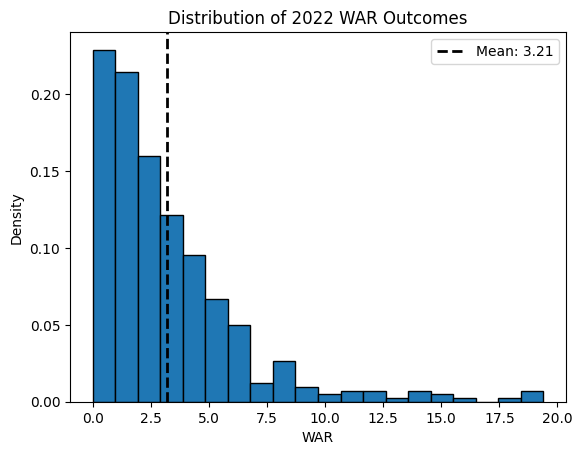

In [ ]:
## Distribution of 2022 WAR Outcomes for each election
plt.hist(war_df_2022["outcome"], bins = 20, edgecolor = "black", density = True)
mean = war_df_2022["outcome"].mean()
plt.axvline(mean, color = "black", linestyle = "dashed", linewidth = 2, label = f"Mean: {mean:.2f}")
plt.title("Distribution of 2022 WAR Outcomes")
plt.xlabel("WAR")
plt.ylabel("Density")
plt.legend()
plt.show();

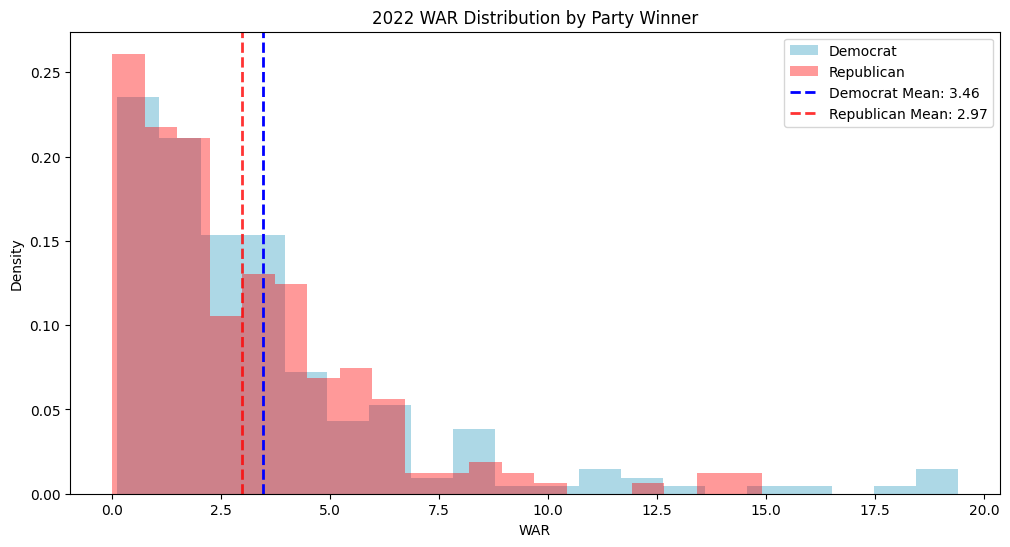

In [ ]:
## 2022 WAR distribution by the party winner
dem_winners = war_df_2022[war_df_2022["Party Winner"] == "Democrat"]["outcome"]
rep_winners = war_df_2022[war_df_2022["Party Winner"] == "Republican"]["outcome"]
mean_dem = dem_winners.mean()
mean_rep = rep_winners.mean()

plt.figure(figsize=(12, 6))
plt.hist(dem_winners, bins = 20, color = "lightblue", label = "Democrat", density = True)
plt.hist(rep_winners, bins = 20, color = "red", alpha = 0.4, label = "Republican", density = True)
plt.axvline(mean_dem, color = "blue", linestyle = "dashed", linewidth = 2, label = f"Democrat Mean: {mean_dem:.2f}")
plt.axvline(mean_rep, color = "red", linestyle = "dashed", alpha = 0.8, linewidth = 2, label = f"Republican Mean: {mean_rep:.2f}")

plt.xlabel("WAR")
plt.ylabel("Density")
plt.title("2022 WAR Distribution by Party Winner")
plt.legend()
plt.show();

In [ ]:
## Avg WAR by State
## Indicative of national shift red
state_WAR = war_df_2022.groupby('State Abv')['Sortable'].mean().reset_index()
state_WAR['avg WAR'] = state_WAR['Sortable']
state_WAR = state_WAR.sort_values(by='avg WAR', ascending=False)[['State Abv', 'avg WAR']]

fig = px.choropleth(
    state_WAR,
    locations="State Abv",
    locationmode="USA-states",
    color="avg WAR",
    color_continuous_scale="RdBu_r",
    scope="usa",
    labels={"avg WAR": "Avg WAR"},
    title="Average WAR by State"
)


fig.update_layout(
    geo=dict(showlakes=True, lakecolor="black"),
    margin=dict(l=0, r=0, t=30, b=0)
)


fig.show()

In [ ]:
## Net Party Wins by State Normalized by number of elections in each state
party_wins = war_df_2022.groupby(["State Abv", "Party Winner"]).size().unstack(fill_value=0).reset_index()


party_wins["Total Elections"] = party_wins["Democrat"] + party_wins["Republican"]


party_wins["Net Win Ratio"] = (party_wins["Republican"] - party_wins["Democrat"]) / party_wins["Total Elections"]


fig = px.choropleth(
    party_wins,
    locations="State Abv",
    locationmode="USA-states",
    color="Net Win Ratio",
    color_continuous_scale="RdBu_r",
    scope="usa",
    labels={"Net Win Ratio": "Net Win Ratio"},
    title="Net Party Wins by State (Normalized)"
)


fig.update_layout(
    geo=dict(showlakes=True, lakecolor="black"),
    margin=dict(l=0, r=0, t=30, b=0)
)


fig.show()

In [ ]:
## Stack names in WAR dataset into one column
winners = war_df_2022.copy()
winners["Candidate"] = winners.apply(lambda x: x["Democrat"] if x["Party Winner"] == "Democrat" else x["Republican"], axis = 1)
winners["Party"] = winners["Party Winner"]
winners["WAR"] = winners["outcome"]

losers = war_df_2022.copy()
losers["Candidate"] = losers.apply(lambda x: x["Republican"] if x["Party Winner"] == "Democrat" else x["Democrat"], axis = 1)
losers["Party"] = losers.apply(lambda x: "Republican" if x["Party Winner"] == "Democrat" else "Democrat", axis = 1)
losers["WAR"] = -1 * losers["outcome"]

cols = ["Candidate", "Party", "WAR", "State Abv", "Year"]
winner_loser_df = pd.concat([winners[cols], losers[cols]], ignore_index=True)
# check = winner_loser_df[winner_loser_df["State Abv"] == "AK"]
# print(check)
winner_loser_df.head(10)

,Candidate,Party,WAR,State Abv,Year
0,Mary Peltola,Democrat,19.4,AK,2022
1,Barry Moore,Republican,0.7,AL,2022
2,Mike Rogers,Republican,3.0,AL,2022
3,Rick Neighbors,Democrat,0.2,AL,2022
4,Dale Strong,Republican,2.8,AL,2022
5,Terri Sewell,Democrat,0.6,AL,2022
6,Monte Hodges,Democrat,2.2,AR,2022
7,French Hill,Republican,4.2,AR,2022
8,Lauren Mallett-Hays,Democrat,0.8,AR,2022
9,Bruce Westerman,Republican,1.3,AR,2022


In [ ]:
## Exact Matches Approach
## comparing funding to WAR by exact name matching
## funding shape (4482, 50)

# funding[funding["name"].duplicated()]
funding_no_dupes = funding.drop_duplicates(subset = "name")
funding_no_dupes

def clean_funding_name(name):
    # Remove suffixes and titles
    suffixes = ["JR", "SR", "II", "III", "IV", "DR", "DR.", "REVEREND", "MR", "MRS", "MS", "PROF", "MD", "PHD"]
    name = re.sub(r"\b(?:{})(?:\b|[\.,])".format("|".join(suffixes)), "", name, flags=re.IGNORECASE)

    # Reorder if in "LAST, FIRST" format
    if "," in name:
        last, first_middle = [part.strip() for part in name.split(",", 1)]
        name = f"{first_middle} {last}"

    # Remove extra commas, periods
    name = re.sub(r"[.,]", "", name)
    name = re.sub(r"\s+", " ", name).strip()

    # Keep only first and last name (keep hyphenated last names)
    parts = name.split()
    if len(parts) >= 2:
        name = f"{parts[0]} {parts[-1]}"
    else:
        name = name  # if somehow only one part, keep it

    return name.upper()

funding["name_clean"] = funding["name"].apply(clean_funding_name)

funding_no_dupes = funding.drop_duplicates(subset = "name")
# funding_no_dupes
funding_no_dupes = funding_no_dupes[funding_no_dupes["disbursements"] != 0]
funding_no_dupes
# funding_no_dupes.columns

,name,office,office_full,party,party_full,state,district,district_number,election_districts,election_years,...,office.1,candidate_inactive.1,individual_itemized_contributions,transfers_from_other_authorized_committee,other_political_committee_contributions,state.1,district.1,district_number.1,state_full,name_clean
1,"MEUSER, MARK",S,Senate,REP,REPUBLICAN PARTY,CA,0.0,0.0,{00},{2022},...,S,f,495353.17,0.00,10749.00,CA,0.0,0.0,California,MARK MEUSER
6,"DRIGGERS, CALVIN JOB",S,Senate,REP,REPUBLICAN PARTY,NY,0.0,0.0,"{00,00}","{2022,2024}",...,S,f,5000.00,0.00,0.00,NY,0.0,0.0,New York,CALVIN DRIGGERS
8,"GALE, SEAN",S,Senate,REP,REPUBLICAN PARTY,PA,0.0,0.0,{00},{2022},...,S,f,32999.00,0.00,0.00,PA,0.0,0.0,Pennsylvania,SEAN GALE
13,"MIXON, LUKE",S,Senate,DEM,DEMOCRATIC PARTY,LA,0.0,0.0,{00},{2022},...,S,f,1153913.95,0.00,27750.00,LA,0.0,0.0,Louisiana,LUKE MIXON
14,"MCCRAY, VALERIE L DR",S,Senate,DEM,DEMOCRATIC PARTY,IN,0.0,0.0,"{00,00}","{2022,2024}",...,S,f,3592.99,0.00,0.00,IN,0.0,0.0,Indiana,VALERIE MCCRAY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4474,"AYYAS, SHADI",H,House,DEM,DEMOCRATIC PARTY,VA,10.0,10.0,"{10,05,10}","{2018,2020,2022}",...,H,f,2900.00,0.00,0.00,VA,10.0,10.0,Virginia,SHADI AYYAS
4476,"MILLER, CAROL DEVINE",H,House,REP,REPUBLICAN PARTY,WV,1.0,1.0,"{03,03,01,01,01}","{2018,2020,2022,2024,2026}",...,H,f,514334.66,26921.89,680926.00,WV,1.0,1.0,West Virginia,CAROL MILLER
4477,"STEIL, BRYAN GEORGE",H,House,REP,REPUBLICAN PARTY,WI,1.0,1.0,"{01,01,01,01,01}","{2018,2020,2022,2024,2026}",...,H,f,1798496.72,129908.53,1472429.09,WI,1.0,1.0,Wisconsin,BRYAN STEIL
4478,"THERON, DANIEL PETER",H,House,REP,REPUBLICAN PARTY,WI,2.0,2.0,"{02,02,02,02,02,02}","{2008,2010,2014,2016,2020,2022}",...,H,f,3756.15,0.00,0.00,WI,2.0,2.0,Wisconsin,DANIEL THERON


In [ ]:
funding_no_dupes["name_clean"] = funding_no_dupes["name_clean"].str.strip().str.upper()
winner_loser_df["Candidate"] = winner_loser_df["Candidate"].str.strip().str.upper()

merged_df = winner_loser_df.merge(
    funding_no_dupes[["name_clean", "disbursements"]],
    left_on="Candidate",
    right_on="name_clean",
    how="left"  # Keep all rows from winner_loser_df
)
merged_df = merged_df.dropna().reset_index(drop=True)
merged_df
# unmatched = winner_loser_df[~winner_loser_df["Candidate"].isin(funding_no_dupes["name"])]
# unmatched["Candidate"]
# print("Matches found:", merged_df["disbursements"].notna().sum())
# print("Total rows:", len(merged_df))

,Candidate,Party,WAR,State Abv,Year,name_clean,disbursements
0,MARY PELTOLA,Democrat,19.4,AK,2022,MARY PELTOLA,7060033.09
1,DALE STRONG,Republican,2.8,AL,2022,DALE STRONG,1975308.27
2,TERRI SEWELL,Democrat,0.6,AL,2022,TERRI SEWELL,1706609.01
3,MONTE HODGES,Democrat,2.2,AR,2022,MONTE HODGES,64098.32
4,BRUCE WESTERMAN,Republican,1.3,AR,2022,BRUCE WESTERMAN,1445546.44
...,...,...,...,...,...,...,...
582,RICHARD BLUMENTHAL,Democrat,-1.7,CT,2022,RICHARD BLUMENTHAL,11061587.12
583,KRYSTLE MATTHEWS,Democrat,-3.1,SC,2022,KRYSTLE MATTHEWS,94233.67
584,MARK HOLLAND,Democrat,-5.3,KS,2022,MARK HOLLAND,879547.94
585,PATTY MURRAY,Democrat,-5.3,WA,2022,PATTY MURRAY,23588816.44


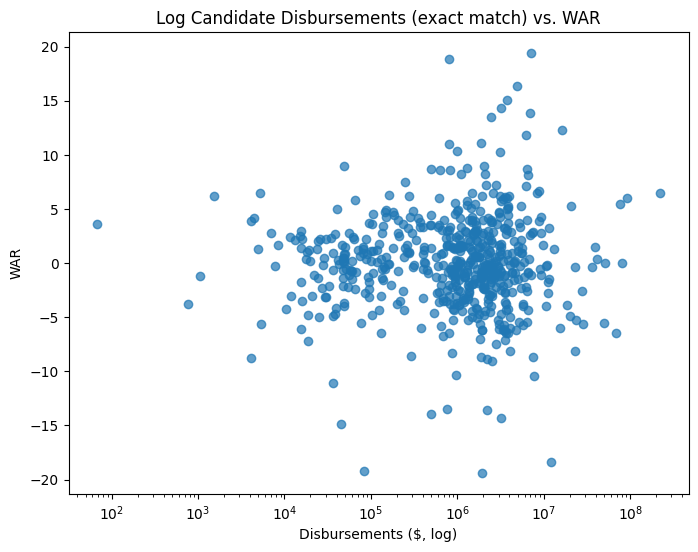

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df["disbursements"], merged_df["WAR"], alpha=0.7)

plt.xscale("log")
plt.xlabel("Disbursements ($, log)")
plt.ylabel("WAR")
plt.title("Log Candidate Disbursements (exact match) vs. WAR")
plt.show()

In [ ]:
## The FUZZZZZZZZZZ
## using fuzz library to approximately match names to compare funding with WAR scores
from rapidfuzz import process, fuzz

funding_names = funding_no_dupes[["name_clean", "party", "name", "disbursements"]]

party_map = {"REPUBLICAN": "REP", "DEMOCRAT": "DEM"}

matches = []

for _, row in winner_loser_df.iterrows():
    candidate = row["Candidate"]
    party = row["Party"].upper()

    if party in party_map:
        abbr = party_map[party]
        subset = funding_names[funding_names["party"] == abbr]

        if not subset.empty:
            match = process.extractOne(
                candidate,
                subset["name_clean"],
                scorer=fuzz.token_sort_ratio
            )

            if match:
                matched_name_clean = match[0]
                match_score = match[1]

                match_row = subset[subset["name_clean"] == matched_name_clean].iloc[0]

                matches.append({
                    "Candidate": candidate,
                    "Party": party,
                    "State Abv": row["State Abv"],
                    "Year": row["Year"],
                    "WAR": row["WAR"],
                    "match_name": matched_name_clean,
                    "Funding Name": match_row["name"],
                    "Funding Party": match_row["party"],
                    "disbursements": match_row["disbursements"],
                    "match_score": match_score
                })

merged_fuzz_df = pd.DataFrame(matches).sort_values(by="match_score", ascending=True)
merged_fuzz_filtered = merged_fuzz_df[merged_fuzz_df["match_score"] >= 81].reset_index(drop=True)
merged_fuzz_filtered
# print("Matches found:", merged_fuzz_df["disbursements"].notna().sum())
# print("Total rows:", len(merged_fuzz_df))

,Candidate,Party,State Abv,Year,WAR,match_name,Funding Name,Funding Party,disbursements,match_score
0,MICHELLE GARCIA HOLMES,REPUBLICAN,NM,2022,3.8,MICHELLE HOLMES,"GARCIA HOLMES, MICHELLE",REP,401736.80,81.081081
1,MARJORIE TAYLOR GREENE,REPUBLICAN,GA,2022,-12.3,MARJORIE GREENE,"GREENE, MARJORIE TAYLOR MRS.",REP,11001460.90,81.081081
2,CATHERINE CORTEZ MASTO,DEMOCRAT,NV,2022,3.9,CATHERINE MASTO,"CORTEZ MASTO, CATHERINE",DEM,64370360.54,81.081081
3,CHRIS PALOMBI,REPUBLICAN,MD,2022,5.0,CHRISTOPHER PALOMBI,"PALOMBI, CHRISTOPHER",REP,64701.11,81.250000
4,CHRIS DELUZIO,DEMOCRAT,PA,2022,1.2,CHRISTOPHER DELUZIO,"DELUZIO, CHRISTOPHER",DEM,3271004.88,81.250000
...,...,...,...,...,...,...,...,...,...,...
695,MIKE THOMPSON,DEMOCRAT,CA,2022,1.0,MIKE THOMPSON,"THOMPSON, MIKE MR.",DEM,2396636.82,100.000000
696,KERMIT JONES,DEMOCRAT,CA,2022,0.8,KERMIT JONES,"JONES, KERMIT",DEM,3230693.36,100.000000
697,DOUGLAS BROWER,REPUBLICAN,CA,2022,1.4,DOUGLAS BROWER,"BROWER, DOUGLAS REV",REP,15677.00,100.000000
698,MAX STEINER,DEMOCRAT,CA,2022,3.5,MAX STEINER,"STEINER, MAX",DEM,611213.96,100.000000


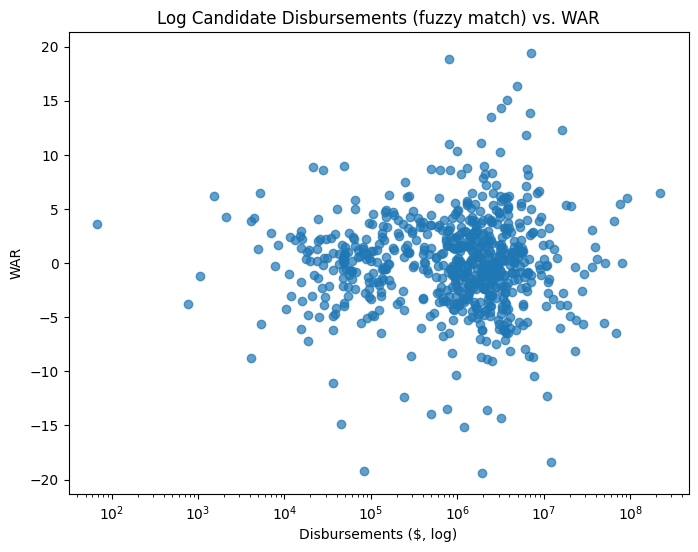

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_fuzz_filtered["disbursements"], merged_fuzz_filtered["WAR"], alpha=0.7)

plt.xscale("log")
plt.xlabel("Disbursements ($, log)")
plt.ylabel("WAR")
plt.title("Log Candidate Disbursements (fuzzy match) vs. WAR")
plt.show()

## Categorical Variable 1 -- Incumbency

In [ ]:
dem_candidates = pd.read_csv("dem_candidates.csv")
rep_candidates = pd.read_csv("rep_candidates.csv")

In [ ]:
print("There are", dem_candidates.shape[0], "democrat candidates in the dataset.")
dem_candidates['Incumbent'].value_counts()

There are 1077 democrat candidates in the dataset.


,count
Incumbent,
No,862
Yes,215


In [ ]:
print("There are", rep_candidates.shape[0], "republican candidates in the dataset.")
rep_candidates['Incumbent'].value_counts()

There are 1599 republican candidates in the dataset.


,count
Incumbent,
No,1383
Yes,216


There are a similar number of incumbent candidates in the democratic and republican parties, but there are 521 more non-incumbent candidates in the republican party

In [ ]:
# Now I will join the republican and democrat datasets together to analyze patterns in incumbency status
rep_candidates['Party'] = 'Republican'
dem_candidates['Party'] = 'Democrat'
all_candidates = pd.concat([rep_candidates, dem_candidates], ignore_index=True)
all_candidates['Primary Votes'] = all_candidates['Primary Votes'].replace(',', '', regex=True)
all_candidates['Primary Votes'] = pd.to_numeric(all_candidates['Primary Votes'], errors='coerce')


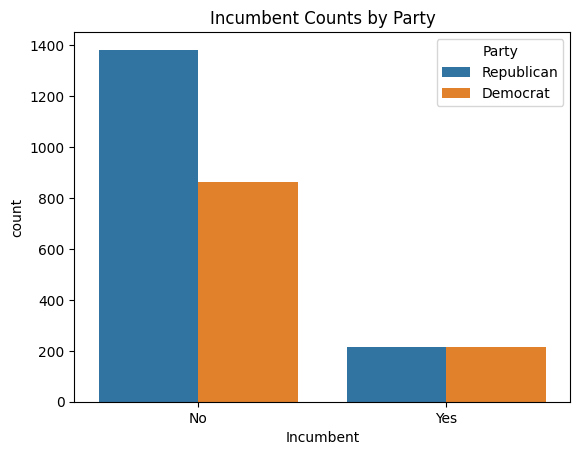

In [ ]:
# First, let's visualize the difference in number of incumbents and non-incumbents between the parties
sns.countplot(data=all_candidates, x='Incumbent', hue='Party')
plt.title('Incumbent Counts by Party')
plt.show()

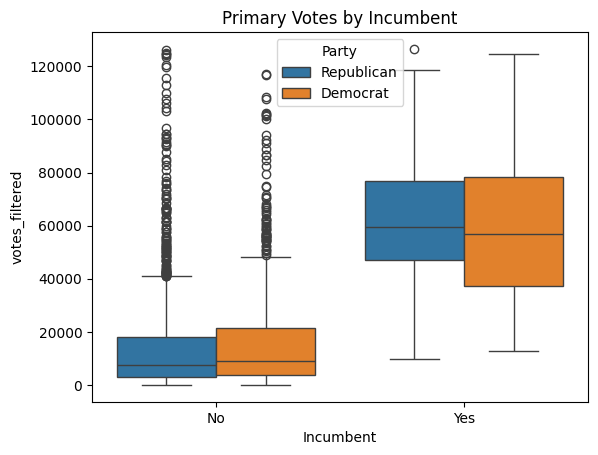

In [ ]:
# Now I want to visualize the number of votes each candidate recieved, grouped by party and incumbency status (yes or no)
# First remove outliers in number of votes
lower = all_candidates['Primary Votes'].quantile(0.05)
upper = all_candidates['Primary Votes'].quantile(0.95)
all_candidates['votes_filtered'] = all_candidates[(all_candidates['Primary Votes'] > lower) & (all_candidates['Primary Votes'] < upper)]['Primary Votes']

sns.boxplot(x='Incumbent', y='votes_filtered', data=all_candidates, hue="Party")
plt.title('Primary Votes by Incumbent')
plt.show()

In [ ]:
# Let's look at the different in number of total votes received for incumbents versus non-incumbents
all_candidates.groupby('Incumbent')['Primary Votes'].agg("mean").round(2)

,Primary Votes
Incumbent,
No,29263.48
Yes,105520.27


In [ ]:
# Next, let's run a chi-squared test to see how incumbency status is related to the outcome of the election
from scipy.stats import chi2_contingency
contingency = pd.crosstab(all_candidates['Incumbent'], all_candidates["Primary Outcome"])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-squared statistic:", chi2)
print("p-value:", p)

Chi-squared statistic: 819.8990004413743
p-value: 9.145220794096961e-179


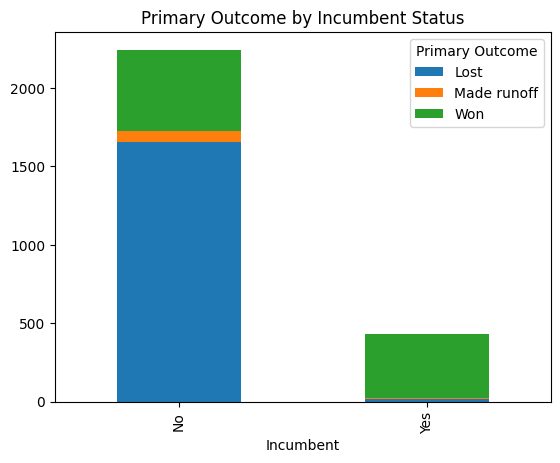

In [ ]:
# Now, let's plot the election results by incumbency status
pd.crosstab(all_candidates['Incumbent'], all_candidates['Primary Outcome']).plot(kind='bar', stacked=True)
plt.title('Primary Outcome by Incumbent Status')
plt.show()

## Categorical Variable 2 -- Race (caedin)

In [ ]:
# load data
dem_candidates = pd.read_csv("dem_candidates.csv")
dem_candidates['Party'] = 'D'
dem_candidates.shape

(1077, 27)

In [ ]:
#load_data
rep_candidates = pd.read_csv("rep_candidates.csv")
rep_candidates['Party'] = 'R'
rep_candidates.shape

(1599, 28)

In [ ]:
# we can see that the datasets have a different number of features, lets inspect the columns to see what they are
dem_candidates.columns

Index(['Candidate', 'Gender', 'Race 1', 'Race 2', 'Race 3', 'Incumbent',
       'Incumbent Challenger', 'State', 'Primary Date', 'Office', 'District',
       'Primary Votes', 'Primary %', 'Primary Outcome', 'Runoff Votes',
       'Runoff %', 'Runoff Outcome', 'EMILY's List', 'Justice Dems',
       'Indivisible', 'PCCC', 'Our Revolution', 'Sunrise', 'Sanders', 'AOC',
       'Party Committee', 'Party'],
      dtype='object')

In [ ]:
rep_candidates.columns

Index(['Candidate', 'Gender', 'Race 1', 'Race 2', 'Race 3', 'Incumbent',
       'Incumbent Challenger', 'State', 'Primary Date', 'Office', 'District',
       'Primary Votes', 'Primary %', 'Primary Outcome', 'Runoff Votes',
       'Runoff %', 'Runoff Outcome', '2020 Election Stance', 'Trump',
       'Trump Date', 'Club for Growth', 'Party Committee', 'Renew America',
       'E-PAC', 'VIEW PAC', 'Maggie's List', 'Winning for Women', 'Party'],
      dtype='object')

In [ ]:
# The columns differ due to different endorsements available for each party. We will ignore these and concatenate the two tables
dem_info = dem_candidates[['Candidate', 'Party', 'Gender', 'Race 1', 'Race 2', 'Race 3', 'Incumbent',
      'Incumbent Challenger', 'State', 'Primary Date', 'Office', 'District',
      'Primary Votes', 'Primary %', 'Primary Outcome', 'Runoff Votes',
      'Runoff %', 'Runoff Outcome']]


rep_info = rep_candidates[['Candidate', 'Party', 'Gender', 'Race 1', 'Race 2', 'Race 3', 'Incumbent',
      'Incumbent Challenger', 'State', 'Primary Date', 'Office', 'District',
      'Primary Votes', 'Primary %', 'Primary Outcome', 'Runoff Votes',
      'Runoff %', 'Runoff Outcome']]


candidate_info = pd.concat([dem_info, rep_info], ignore_index=True)
candidate_info.shape

(2676, 18)

### Lets examine the racial makeup among parties and see how race is correlated with political affiliation

In [ ]:
# Lets take a look at what unique values makeup our Race columns
# Inspect unique values in Race 1
print("Unique values in Race 1:")
print(candidate_info['Race 1'].dropna().unique())


# Inspect unique values in Race 2
print("\nUnique values in Race 2:")
print(candidate_info['Race 2'].dropna().unique())


# Inspect unique values in Race 3
print("\nUnique values in Race 3:")
print(candidate_info['Race 3'].dropna().unique())

Unique values in Race 1:
['White' 'Black' 'Asian (Indian)' 'Latino' 'Latino (Mexican)'
 'Latino (Puerto Rican)' 'Unknown' 'Black (Eritrean)'
 'Asian (Bangladeshi)' 'White ' 'Latino (Peruvian)'
 'Middle Eastern (Saudi)' 'Latino (Ecuadorian)' 'Black (Nigerian)'
 'Native American (Saponi)' 'White (Azerbaijani)'
 'Middle Eastern (Palestinian)' 'Latino (Venezuelan)'
 'Native American (Comanche)' 'Asian' 'Native American' 'Asian (Korean)'
 'White (Polish)' 'Latino (Cuban)' 'Latino (Colombian)' 'Asian (Japanese)'
 'Latino (Salvadoran)' 'Asian (Pakistani)' 'Middle Eastern (Armenian)'
 'Asian (Chinese)' 'Middle Eastern (Iranian)' 'Latino (Guatemalan)'
 'Asian (Taiwanese)' 'Latino (Puerto Rican / Ecuadorian)'
 'Asian (Filipino)' 'Native American (Lakota)' 'Asian (Thai)'
 'Native American (Cherokee)' 'Native American (Creek / Yuchi)'
 'White (Albanian)' 'Latino (Dominican)' 'White (Belgian)'
 'Native American (Ho-Chunk)' 'Latino (Chilean)' 'Black (Ethiopian)'
 'Black (Somali)' 'Black (Jamaican)' 

In [ ]:
# We have a lot of unique values making it hard to visualize general patterns, lets simplify these races into more general categories
# The values in Race 1, 2 and 3 are nicely formatted for us so we can use a Regex Pattern to capture the first part
import re


# Function to map race using regex
def map_race(race):
   if pd.isna(race):
       return 'Unknown'


   if re.match(r'^White', race):
       return 'White'
   elif re.match(r'^Black', race):
       return 'Black'
   elif re.match(r'^Asian', race):
       return 'Asian'
   elif re.match(r'^Latino', race):
       return 'Latino'
   elif re.match(r'^Native', race):
       return 'Other'
   elif re.match(r'^Middle Eastern|^Arab', race):
       return 'Other'
   elif re.match(r'^Pacific', race):
       return 'Other'
   else:
       return 'Unknown'

In [ ]:
# Now lets melt our three race columns into one and apply our mapping function
race_cols = ['Race 1', 'Race 2', 'Race 3']
race_df = candidate_info.melt(id_vars=['Candidate', 'Party'], value_vars=race_cols, value_name='Race')
race_df = race_df.dropna(subset=['Race'])
race_df['Broad Race'] = race_df['Race'].apply(map_race)

# this dataframe will allow us to create a visualization of race among parties

In [ ]:
# Count number of candidates by Race and Party
race_counts = race_df.groupby(['Broad Race', 'Party']).size().reset_index(name='Count')
print(race_counts)

   Broad Race Party  Count
0       Asian     D     61
1       Asian     R     56
2       Black     D    300
3       Black     R    123
4      Latino     D    121
5      Latino     R    104
6       Other     D     25
7       Other     R     29
8     Unknown     D     18
9     Unknown     R     50
10      White     D    583
11      White     R   1268


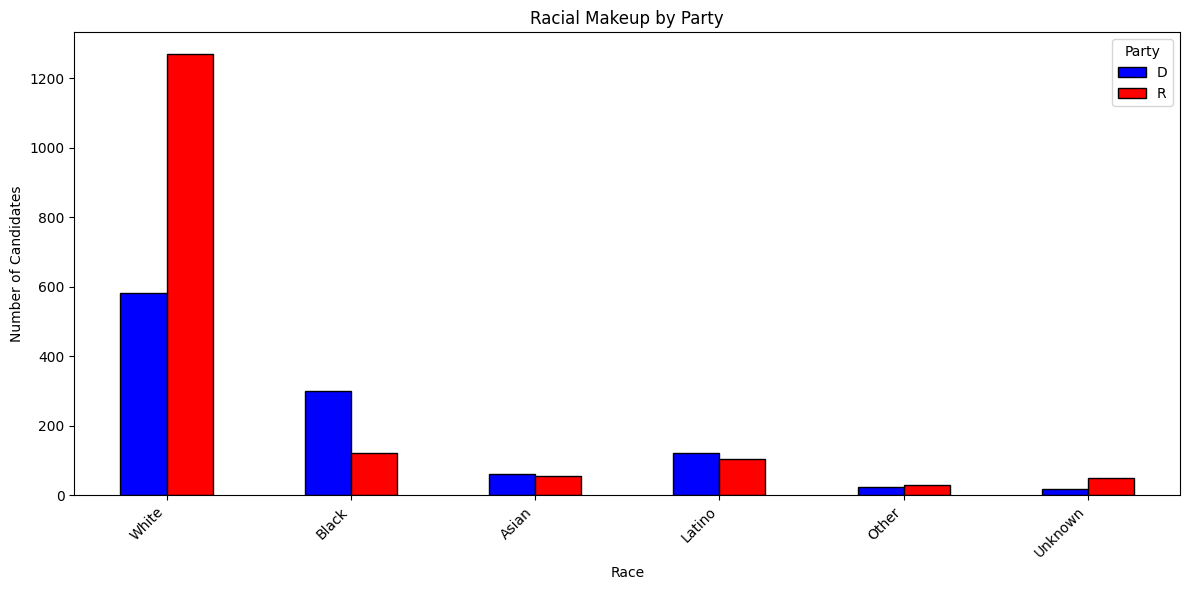

In [ ]:
race_order = ['White', 'Black', 'Asian', 'Latino', 'Other', 'Unknown']


# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 6))


# Pivot the data so each party is a different bar
race_pivot = race_counts.pivot(index='Broad Race', columns='Party', values='Count').fillna(0)
race_pivot = race_pivot.reindex(race_order)


race_pivot.plot(kind='bar', ax=ax, color=['blue', 'red'], edgecolor='black')


plt.title('Racial Makeup by Party')
plt.ylabel('Number of Candidates')
plt.xlabel('Race')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Party')
plt.tight_layout()


plt.show()

As we can see, there are significant differences in the racial makeup between parties. The Democratic party has a significantly larger number of Black candidates and slightly more Asian and Latino candidates as well while the Republican party has significantly more White candidates.

### Now lets examine how race is correlated with Primary success

In [ ]:
# combine our generalized Race columns with Primary Outcome information from our original dataframe
race_and_outcome = race_df.merge(candidate_info[['Candidate', 'Primary Outcome', 'Party']], on=['Candidate', 'Party'], how='left')

# create a binary value for whether the candidate won or not
race_and_outcome['Primary Win'] = race_and_outcome['Primary Outcome'].apply(lambda x: 1 if x == 'Won' else 0)

win_rates = race_and_outcome.groupby(['Broad Race', 'Party'])['Primary Win'].mean().reset_index()
win_rates['Broad Race'] = pd.Categorical(win_rates['Broad Race'], categories=race_order, ordered=True)
dem_win_rates = win_rates[win_rates['Party'] == 'D']
rep_win_rates = win_rates[win_rates['Party'] == 'R']


Lets plot our win rates by Race for each party to see how different Races perform given their Party.
This interaction is important to consider when examining the causal effect of campaign funding on Primary performance.

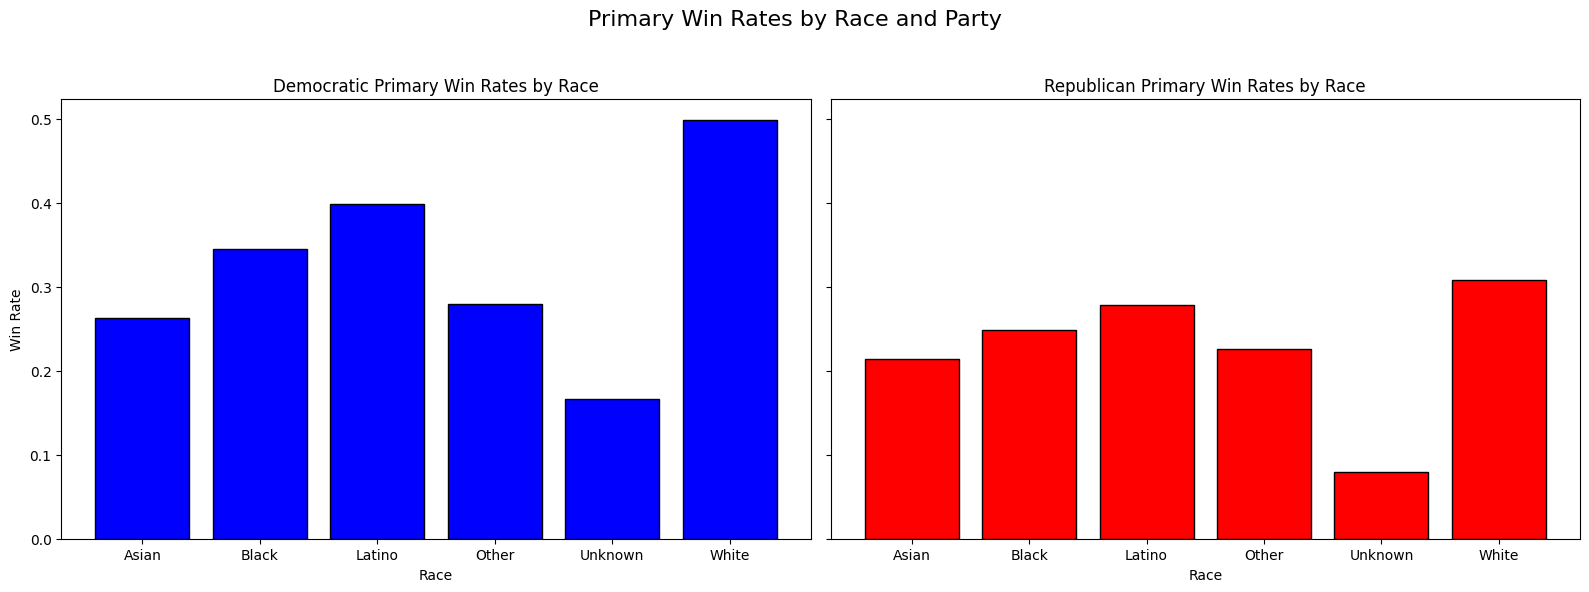

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

race_win_order = ['White', 'Black', 'Asian', 'Latino', 'Other', 'Unknown']

axes[0].bar(dem_win_rates['Broad Race'], dem_win_rates['Primary Win'], color='blue', edgecolor='black')
axes[0].set_title('Democratic Primary Win Rates by Race')
axes[0].set_ylabel('Win Rate')
axes[0].set_xlabel('Race')

axes[1].bar(rep_win_rates['Broad Race'], rep_win_rates['Primary Win'], color='red', edgecolor='black')
axes[1].set_title('Republican Primary Win Rates by Race')
axes[1].set_xlabel('Race')

plt.suptitle('Primary Win Rates by Race and Party', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

These graphs are hard to compare because Democratic primary elections were generally less competetive i.e. there were less candidates. This means that the Primary win rates were higher across the board for Democrats versus Republicans. This makes our graphs hard to compare. Instead of looking at raw win rates (which are biased because Democrats have fewer candidates and less competition),
lets look at the composition of winners by race inside each party. This answers the question: "Of all primary winner of a given party, what percentage were White, Black, Latino, etc.?"

In [ ]:
winners = race_and_outcome[race_and_outcome['Primary Win'] == 1]
winner_counts = winners.groupby(['Broad Race', 'Party']).size().reset_index(name='Count')
winner_counts['Percentage'] = winner_counts.groupby('Party')['Count'].transform(lambda x: x / x.sum())

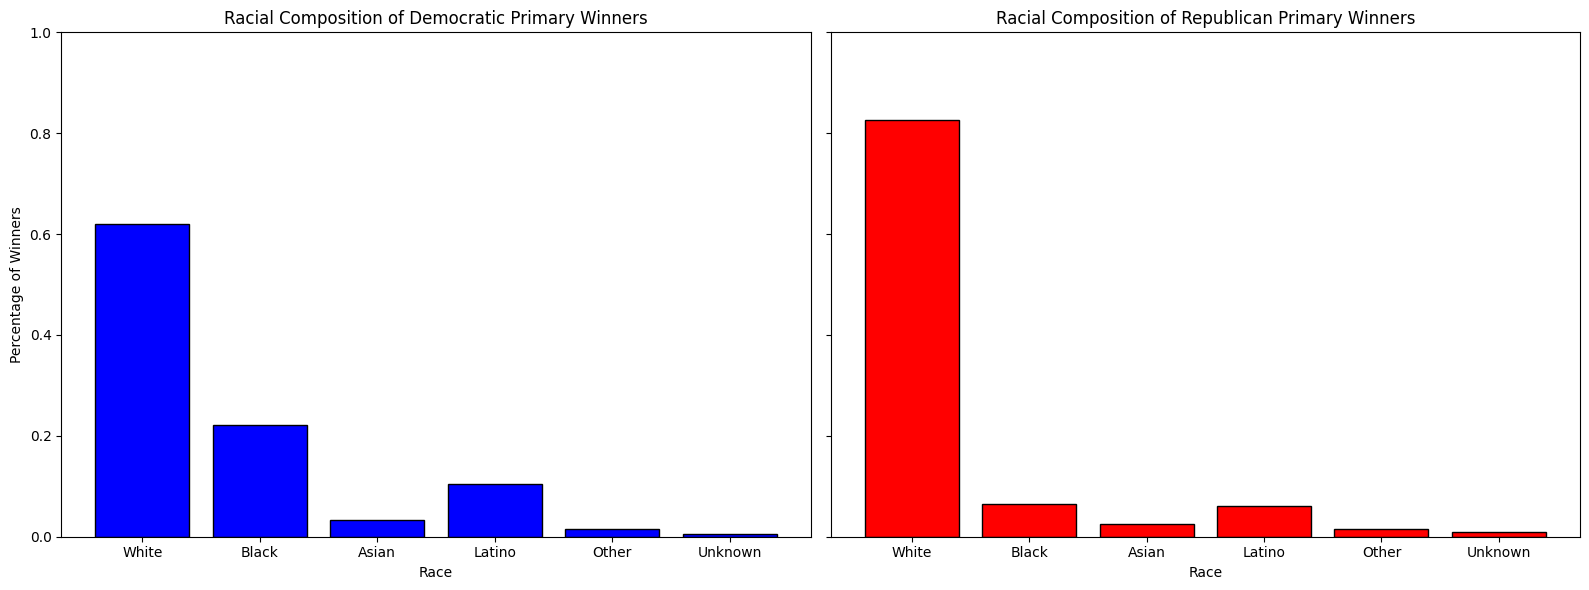

In [ ]:
dem_winner_dist = winner_counts[winner_counts['Party'] == 'D'].copy()
rep_winner_dist = winner_counts[winner_counts['Party'] == 'R'].copy()

dem_winner_dist['Broad Race'] = pd.Categorical(dem_winner_dist['Broad Race'], categories=race_order, ordered=True)
rep_winner_dist['Broad Race'] = pd.Categorical(rep_winner_dist['Broad Race'], categories=race_order, ordered=True)
dem_winner_dist = dem_winner_dist.sort_values('Broad Race')
rep_winner_dist = rep_winner_dist.sort_values('Broad Race')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
winners_race_order = ['White', 'Black', 'Latino', 'Asian', 'Other', 'Unknown']

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

# Democrat plot
axes[0].bar(dem_winner_dist['Broad Race'], dem_winner_dist['Percentage'], color='blue', edgecolor='black')
axes[0].set_title('Racial Composition of Democratic Primary Winners')
axes[0].set_ylabel('Percentage of Winners')
axes[0].set_xlabel('Race')

# Republican plot
axes[1].bar(rep_winner_dist['Broad Race'], rep_winner_dist['Percentage'], color='red', edgecolor='black')
axes[1].set_title('Racial Composition of Republican Primary Winners')
axes[1].set_xlabel('Race')

plt.tight_layout()
plt.show()

This is a much better way to visualize how candidates of each race tend to perform within each parties Primaries.

We can see that there are clear differences in the racial makeup of winning primary campaigns among the Democratic and Republican parties. This interaction hints that both party and race could be confounders and should be considered when finding the causal effect of financing. For example, a black candidate in the Republican party may recieve less funding and have a poor primary performance, however, without accounting for the confounding factor of race and party affiliation, we may incorrectly infer a causal effect of campaign financing on Primary outcome/performance.

In [ ]:
print("END")

END


# Research Question 1

In [ ]:
## MHT between political endorsements and election outcomes in 2022 primaries
rep_candidates['Party'] = 'Republican'
dem_candidates['Party'] = 'Democrat'
all_candidates_full = pd.concat([rep_candidates, dem_candidates], ignore_index=True)
all_candidates_full['Primary Votes'] = all_candidates_full['Primary Votes'].replace(',', '', regex=True)
all_candidates_full['Primary Votes'] = pd.to_numeric(all_candidates_full['Primary Votes'], errors='coerce')
# all_candidates_full

Cleaning Up Data Sets

In [ ]:
rep_candidates = pd.read_csv("rep_candidates.csv")
rep_candidates_copy = rep_candidates.copy()
endorsements_rep = [
    'Trump', 'Club for Growth', 'Renew America', 'E-PAC',
    'VIEW PAC', "Maggie's List", 'Winning for Women'
]
rep_candidates_copy[endorsements_rep] = rep_candidates_copy[endorsements_rep].replace({'Yes (runoff only)': 'Yes', 'No (runoff only)': 'No'})
rep_candidates_copy[endorsements_rep] = rep_candidates_copy[endorsements_rep].fillna('No')
rep_candidates_copy[endorsements_rep] = rep_candidates_copy[endorsements_rep].map(lambda x: 1 if x == 'Yes' else 0)
rep_candidates_copy['Incumbent'] = rep_candidates_copy['Incumbent'].map({'Yes': 1, 'No': 0})
rep_candidates_copy['Incumbent Challenger'] = rep_candidates_copy['Incumbent Challenger'].map({'Yes': 1, 'No': 0})
rep_candidates_copy["Race"] = rep_candidates_copy["Race 1"].apply(map_race)
rep_candidates_copy['District'] = rep_candidates_copy['District'].replace("At-Large", 100)
rep_candidates_copy['District'] = rep_candidates_copy['District'].fillna(100)
rep_candidates_copy = rep_candidates_copy[~((rep_candidates_copy['Primary Outcome'] == 'Made runoff') & (rep_candidates_copy['Runoff Outcome'].isna()))]

race_dummies = pd.get_dummies(
    rep_candidates_copy['Race'],
    drop_first=False,
    dtype=int
)
race_dummies = race_dummies.drop(columns=['White'])
# race_dummies = race_dummies.drop(columns=['Black'])

state_dummies = pd.get_dummies(
    rep_candidates_copy['State'],
    drop_first=False,
    dtype=int
)
state_dummies = state_dummies.drop(columns=['California'])

district_dummies = pd.get_dummies(
    rep_candidates_copy['District'],
    drop_first=True,
    dtype=int
)

gender_dummies = pd.get_dummies(
    rep_candidates_copy['Gender'],
    drop_first=True,
    dtype=int
)

confounders_df_rep = pd.concat([
    rep_candidates_copy['Incumbent'],
    race_dummies,
    state_dummies,
    # district_dummies,
    gender_dummies
], axis=1)


scaler = StandardScaler()
scaled_confounders_rep = pd.DataFrame(
    scaler.fit_transform(confounders_df_rep),
    columns=confounders_df_rep.columns,
    index=confounders_df_rep.index
)

# scaled_confounders
confounders_df_rep
# rep_candidates_copy
# race_dummies.sum()
## Sanity Check
# for col in endorsements_rep:
#     print(rep_candidates_copy[col].value_counts(dropna=False))
#     print()

,Incumbent,Asian,Black,Latino,Other,Unknown,Alabama,Alaska,Arizona,Arkansas,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Male
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1595,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1596,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# sparse_states = state_dummies.columns[state_dummies.sum() < 10]
# print("Sparse state dummies:")
# print(sparse_states)

# sparse_districts = district_dummies.columns[district_dummies.sum() < 10]
# print("Sparse district dummies:")
# print(sparse_districts)

# sparse_race = race_dummies.columns[race_dummies.sum() < 10]
# print("Sparse race dummies:")
# print(sparse_race)


# state_dummies = state_dummies.drop(columns=sparse_states)
# district_dummies = district_dummies.drop(columns=sparse_districts)

# confounders_df = pd.concat([
#     rep_candidates_copy['Incumbent'],
#     race_dummies,
#     state_dummies,
#     district_dummies,
#     gender_dummies
# ], axis=1)

# scaled_confounders = pd.DataFrame(
#     scaler.fit_transform(confounders_df),
#     columns=confounders_df.columns,
#     index=confounders_df.index
# )

In [ ]:
## Multi-Col Check
# constant_cols = confounders_df.columns[confounders_df.nunique() <= 1]
# print("Constant columns:", constant_cols.tolist())

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# X_conf = add_constant(confounders_df, has_constant='add')  # add intercept term
# vif_data = pd.DataFrame()
# vif_data["Variable"] = X_conf.columns
# vif_data["VIF"] = [variance_inflation_factor(X_conf.values, i) for i in range(X_conf.shape[1])]
# vif_data_sorted = vif_data.sort_values('VIF', ascending=False)
# vif_data_sorted

In [ ]:
dem_candidates = pd.read_csv("dem_candidates.csv")
dem_candidates_copy = dem_candidates.copy()

## Endorsements List
endorsements_dem = [
    "EMILY's List", 'Justice Dems', 'Indivisible', 'PCCC',
    'Our Revolution', 'Sunrise', 'Sanders', 'AOC'
]

## Convert endorsement Data to 1's and 0's
dem_candidates_copy[endorsements_dem] = dem_candidates_copy[endorsements_dem].replace({'Yes (runoff only)': 'Yes','No (runoff only)': 'No'})
dem_candidates_copy[endorsements_dem] = dem_candidates_copy[endorsements_dem].fillna('No')
dem_candidates_copy[endorsements_dem] = dem_candidates_copy[endorsements_dem].map(lambda x: 1 if x == 'Yes' else 0)

## Consolidate race data to avoid data sparsity
dem_candidates_copy["Race"] = dem_candidates_copy["Race 1"].apply(map_race)

## Convert Incumbent and Incumbent Challenger Data to 1's and 0's
dem_candidates_copy['Incumbent'] = dem_candidates_copy['Incumbent'].map({'Yes': 1, 'No': 0})
dem_candidates_copy['Incumbent Challenger'] = dem_candidates_copy['Incumbent Challenger'].map({'Yes': 1, 'No': 0})

## All elections without a district and at-large converted to district 100 as a proxy "district"
dem_candidates_copy['District'] = dem_candidates_copy['District'].replace("At-Large", 100)
dem_candidates_copy['District'] = dem_candidates_copy['District'].fillna(100)

## Remove candidates with no election outcome data
dem_candidates_copy = dem_candidates_copy[~((dem_candidates_copy['Primary Outcome'] == 'Made runoff') & (dem_candidates_copy['Runoff Outcome'].isna()))]

## Race dummies
race_dummies_dem = pd.get_dummies(
    dem_candidates_copy['Race'],
    drop_first=False,
    dtype=int
)
race_dummies_dem = race_dummies_dem.drop(columns=['White'])

## State dummies
state_dummies_dem = pd.get_dummies(
    dem_candidates_copy['State'],
    drop_first=False,
    dtype=int
)
state_dummies_dem = state_dummies_dem.drop(columns=['California']) # California as the base

## District dummies
district_dummies_dem = pd.get_dummies(
    dem_candidates_copy['District'],
    drop_first=True,
    dtype=int
)

## Gender dummies
gender_dummies_dem = pd.get_dummies(
    dem_candidates_copy['Gender'],
    drop_first=True,
    dtype=int
)
gender_dummies_dem = gender_dummies_dem.drop(columns=['Nonbinary']) # remvoe the one entry of non-binary to avoid data sparsity

## confounders data frame
confounders_df_dem = pd.concat([
    dem_candidates_copy['Incumbent'],
    race_dummies_dem,
    state_dummies_dem,
    # district_dummies_dem,
    gender_dummies_dem
], axis=1)

## Normlaized confounders data frame
scaler_dem = StandardScaler()
scaled_confounders_dem = pd.DataFrame(
    scaler_dem.fit_transform(confounders_df_dem),
    columns=confounders_df_dem.columns,
    index=confounders_df_dem.index
)

confounders_df_dem.head()

## Sanity Check
# for col in endorsements_dem:
#     print(dem_candidates_copy[col].value_counts(dropna=False))
#     print()

,Incumbent,Asian,Black,Latino,Other,Unknown,Alabama,Alaska,Arizona,Arkansas,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Male
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
def get_final_outcome(row):
    if row['Primary Outcome'] == 'Won':
        return 'Won'
    elif row['Primary Outcome'] == 'Lost':
        return 'Lost'
    else:
        return row['Runoff Outcome']

In [ ]:
dem_candidates_copy['Final Outcome'] = dem_candidates_copy.apply(get_final_outcome, axis=1)
dem_candidates_copy['Final Outcome'] = dem_candidates_copy['Final Outcome'].map({'Won': 1, 'Lost': 0})
dem_candidates_copy.value_counts('Final Outcome')

,count
Final Outcome,
0,594
1,471


In [ ]:
## dem candidates MHT
pvals_dem = []
coefs_dem = []
std_errs_dem = []

tp_dem = []
fp_dem = []
tn_dem = []
fn_dem = []

confounders_df_dem

for endorsement in endorsements_dem:
    X = pd.concat([
      sm.add_constant(dem_candidates_copy[[endorsement]]),
      scaled_confounders_dem
    ], axis=1)
    y = dem_candidates_copy['Final Outcome']

    model = sm.Logit(y, X)
    result = model.fit(disp=False, maxiter = 1000)
    # print(result.mle_retvals

    y_pred_prob = result.predict(X)
    y_pred = (y_pred_prob >= 0.5).astype(int) # win if y prediction from model is >= 0.5, loss otherwise

    tp = ((y == 1) & (y_pred == 1)).sum()
    fp = ((y == 0) & (y_pred == 1)).sum()
    tn = ((y == 0) & (y_pred == 0)).sum()
    fn = ((y == 1) & (y_pred == 0)).sum()

    tp_dem.append(tp)
    fp_dem.append(fp)
    tn_dem.append(tn)
    fn_dem.append(fn)

    # Check if logistic regression fails to converge
    if not result.mle_retvals['converged']:
        print(f"WARNING: Model for '{endorsement}' did not converge.")

    pvals_dem.append(result.pvalues[endorsement])
    coefs_dem.append(result.params[endorsement])
    std_errs_dem.append(result.bse[endorsement])

## Naive
alpha = 0.05
naive_decisions_dem = np.array(pvals_dem) < alpha

## Bonferroni
bonf_decisions_dem = np.array(pvals_dem) < (alpha / len(pvals_dem))

## BH
_, bh_corrected_pvals_dem, _, _ = multipletests(pvals_dem, alpha=alpha, method='fdr_bh')
bh_decisions_dem = bh_corrected_pvals_dem < alpha

## Results
results_df_dem = pd.DataFrame({
    'Endorsement': endorsements_dem,
    'Coefficient': coefs_dem,
    'p-value': pvals_dem,
    'Standard Error': std_errs_dem,
    'Naive Reject (p < 0.05)': naive_decisions_dem,
    'Bonferroni Reject': bonf_decisions_dem,
    'BH-corrected p-value': bh_corrected_pvals_dem,
    'BH Reject': bh_decisions_dem,
    'TP': tp_dem,
    'FP': fp_dem,
    'TN': tn_dem,
    'FN': fn_dem
})

results_df_dem['Power (TPR)'] = results_df_dem['TP'] / (results_df_dem['TP']  + results_df_dem['FN'])

results_df_dem = results_df_dem.sort_values('p-value')
results_df_dem

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp



/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,Endorsement,Coefficient,p-value,Standard Error,Naive Reject (p < 0.05),Bonferroni Reject,BH-corrected p-value,BH Reject,TP,FP,TN,FN,Power (TPR)
0,EMILY's List,2.258303,0.000002,0.478868,True,True,0.000019,True,294,53,541,177,0.624204
6,Sanders,1.242621,0.045155,0.620315,True,False,0.180618,False,299,68,526,172,0.634820
2,Indivisible,0.968639,0.086907,0.565812,False,False,0.231751,False,299,68,526,172,0.634820
4,Our Revolution,0.702042,0.188263,0.533574,False,False,0.376527,False,300,71,523,171,0.636943
3,PCCC,-0.674572,0.285042,0.630995,False,False,0.456067,False,300,67,527,171,0.636943
7,AOC,0.545953,0.498262,0.806160,False,False,0.664349,False,299,69,525,172,0.634820
1,Justice Dems,0.473079,0.596436,0.893391,False,False,0.681642,False,299,68,526,172,0.634820
5,Sunrise,0.158534,0.846005,0.816270,False,False,0.846005,False,298,68,526,173,0.632696


In [ ]:
rep_candidates_copy['Final Outcome'] = rep_candidates_copy.apply(get_final_outcome, axis=1)
# rep_candidates_copy['Final Outcome'].value_counts()
rep_candidates_copy['Final Outcome'] = rep_candidates_copy['Final Outcome'].map({'Won': 1, 'Lost': 0})
# rep_candidates_copy

In [ ]:
pvals_rep = []
coefs_rep = []
std_errs_rep = []
# confounders: incumbent, race, disctrict, gender, party

tp_rep = []
fp_rep = []
tn_rep = []
fn_rep = []

for endorsement in endorsements_rep:
    # X = sm.add_constant(rep_candidates_copy[[endorsement]])
    X = pd.concat([
      sm.add_constant(rep_candidates_copy[[endorsement]]),
      scaled_confounders_rep
    ], axis=1)

    y = rep_candidates_copy['Final Outcome']

    model = sm.Logit(y, X)
    result = model.fit(disp=False, maxiter = 1000)
    # print(result.mle_retvals)

    # Check if logistic regression fails to converge
    if not result.mle_retvals['converged']:
        print(f"WARNING: Model for '{endorsement}' did not converge.")

    coefs_rep.append(result.params[endorsement])
    pvals_rep.append(result.pvalues[endorsement])
    std_errs_rep.append(result.bse[endorsement])

    y_pred_prob = result.predict(X)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    tp = ((y == 1) & (y_pred == 1)).sum()
    fp = ((y == 0) & (y_pred == 1)).sum()
    tn = ((y == 0) & (y_pred == 0)).sum()
    fn = ((y == 1) & (y_pred == 0)).sum()

    tp_rep.append(tp)
    fp_rep.append(fp)
    tn_rep.append(tn)
    fn_rep.append(fn)

## Naive
alpha = 0.05
naive_decisions_rep = np.array(pvals_rep) < alpha

## Bonferroni
bonf_decisions_rep = np.array(pvals_rep) < (alpha / len(pvals_rep))

## BH
_, bh_corrected_pvals_rep, _, _ = multipletests(pvals_rep, alpha=alpha, method='fdr_bh')
bh_decisions_rep = bh_corrected_pvals_rep < alpha

## Results
results_df_rep = pd.DataFrame({
    'Endorsement': endorsements_rep,
    'Coefficient': coefs_rep,
    'p-value': pvals_rep,
    'Standard Error': std_errs_rep,
    'Naive Reject (p < 0.05)': naive_decisions_rep,
    'Bonferroni Reject': bonf_decisions_rep,
    'BH-corrected p-value': bh_corrected_pvals_rep,
    'BH Reject': bh_decisions_rep,
    'TP': tp_rep,
    'FP': fp_rep,
    'TN': tn_rep,
    'FN': fn_rep
})

results_df_rep['Power (TPR)'] = results_df_rep['TP'] / (results_df_rep['TP']  + results_df_rep['FN'] )
results_df_rep = results_df_rep.sort_values('p-value')
results_df_rep

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp



/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp



,Endorsement,Coefficient,p-value,Standard Error,Naive Reject (p < 0.05),Bonferroni Reject,BH-corrected p-value,BH Reject,TP,FP,TN,FN,Power (TPR)
0,Trump,3.536867,1.264238e-17,0.413818,True,True,8.849665e-17,True,282,40,1067,203,0.581443
3,E-PAC,3.120822,8.301912e-07,0.633267,True,True,2.905669e-06,True,261,39,1068,224,0.538144
5,Maggie's List,2.190862,2.719229e-06,0.467039,True,True,6.297941e-06,True,261,55,1052,224,0.538144
1,Club for Growth,3.295790,3.598824e-06,0.711327,True,True,6.297941e-06,True,260,36,1071,225,0.536082
2,Renew America,-5.817166,4.615929e-06,1.269700,True,True,6.462301e-06,True,249,30,1077,236,0.513402
6,Winning for Women,2.182788,2.443488e-04,0.595071,True,True,2.850736e-04,True,257,53,1054,228,0.529897
4,VIEW PAC,1.294803,1.886524e-03,0.416665,True,True,1.886524e-03,True,252,35,1072,233,0.519588


# Research Question 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import candidate demographic info and clean it like we did in our EDA section

In [ ]:
dem_candidates = pd.read_csv("dem_candidates.csv")
dem_candidates['Party'] = 'D'
rep_candidates = pd.read_csv("rep_candidates.csv")
rep_candidates['Party'] = 'R'


dem_info = dem_candidates


rep_info = rep_candidates

candidate_info = pd.concat([dem_info, rep_info], ignore_index=True)
candidate_info = candidate_info.rename(columns={'Race 1': 'Race'}, inplace=False)

# # inline changes
# candidate_info.loc[candidate_info['Primary Outcome'] == 'Made runoff', 'Primary Outcome'] = candidate_info['Runoff Outcome']
# candidate_info.drop(columns=['Runoff Outcome', 'Runoff Votes', 'Runoff %'], inplace=True)


candidate_info.head()

,Candidate,Gender,Race,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,Party,2020 Election Stance,Trump,Trump Date,Club for Growth,Renew America,E-PAC,VIEW PAC,Maggie's List,Winning for Women
0,Gavin Dass,Male,White,Asian (Indian),NaN,No,No,Texas,3/1/22,Representative,...,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Victor D. Dunn,Male,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Jrmar ""JJ"" Jefferson",Male,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Stephen Kocen,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Robin Fulford,Female,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
stanford_data_path = "stanford_funding_and_ideology.csv"
stanford_data = pd.read_csv(stanford_data_path)

<ipython-input-59-e7979db710d0>:2: DtypeWarning:

Columns (10,12,15,16,17,41,43,44,45,47,49,50,54,55,58,59,60,61,63) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
stanford_data_2022 = stanford_data[stanford_data['cycle'] == 2022]
stanford_candidate_data = stanford_data_2022[stanford_data_2022['recipient.type'] == 'cand'].copy()
stanford_candidate_data.shape

(18412, 64)

In [ ]:
stanford_candidate_data['full_name'] = (
    stanford_candidate_data['fname'].fillna('') + ' ' + stanford_candidate_data['lname'].fillna('')
).str.strip()

stanford_candidate_data.head()

,election,cycle,fecyear,bonica.rid,bonica.cid,name,lname,ffname,fname,mname,...,NID,before.switch.ICPSR,after.switch.ICPSR,party.orig,nimsp.party,nimsp.candidate.ICO.code,nimsp.district,nimsp.office,nimsp.candidate.status,full_name
67976,fd2022,2022,2022.0,cand1544,5.000004e+15,tammy baldwin victory committee,baldwin,NaN,tammy,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,tammy baldwin
70106,fd2022,2022,2024.0,cand142904,5.000002e+15,"blackburn, marsha",blackburn,marsha,marsha,NaN,...,NS8TN00337,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,marsha blackburn
70107,fd2022,2022,2022.0,cand140855,4.625032e+09,"bartos, jeffrey a",bartos,jeffrey a,jeffrey,a,...,NS8PA00262,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,jeffrey bartos
70108,fd2022,2022,2022.0,cand141327,2.917591e+10,"gibbons, michael",gibbons,michael,michael,NaN,...,NS8OH00086,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,michael gibbons
70109,fd2022,2022,2022.0,cand545,2.565803e+09,"schumer, charles e",schumer,charles e,charles,e,...,N00001093,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,charles schumer


### Fuzzy matching names for merging dataframes

In [ ]:
from rapidfuzz import process, fuzz

# prepare lists
stanford_names = stanford_candidate_data['full_name'].dropna().unique().tolist()
len(stanford_names)

17635

In [ ]:
candidate_info['full_name'] = (candidate_info['Candidate']).str.lower()

In [ ]:
def get_best_match(name, choices, threshold=70):
    match = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= threshold:
        return pd.Series([match[0], match[1]])
    else:
        return pd.Series([None, None])

In [ ]:
candidate_info[['matched_name', 'match_score']] = candidate_info['full_name'].apply(
    lambda x: get_best_match(x, stanford_names)
)


In [ ]:
merged_df = candidate_info.merge(
    stanford_candidate_data,
    left_on='matched_name',
    right_on='full_name',
    how='left'
)
len(merged_df[merged_df['matched_name'].notna()])

2617

In [ ]:
def party_map(party):
  if party == 100:
    return 'D'
  if party == 200:
    return 'R'
  else:
    return 'I'

merged_df['stanford_party'] = merged_df['party'].apply(party_map)

In [ ]:
def state_map(state):
    state_abbrev = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
        'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
        'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
        'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
        'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
        'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
        'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
        'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
        'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
        'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
        'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    return state_abbrev.get(state, None)

merged_df['stanford_state'] = merged_df['state'].apply(state_map)

In [ ]:
merged_df['valid_match?'] = (
    (merged_df['Party'] == merged_df['stanford_party']) &
    (merged_df['State'] == merged_df['stanford_state'])
)

merged_df.head()

,Candidate,Gender,Race,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,party.orig,nimsp.party,nimsp.candidate.ICO.code,nimsp.district,nimsp.office,nimsp.candidate.status,full_name_y,stanford_party,stanford_state,valid_match?
0,Gavin Dass,Male,White,Asian (Indian),NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,gavin dass,D,Texas,True
1,Victor D. Dunn,Male,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,None,False
2,"Jrmar ""JJ"" Jefferson",Male,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,mar jefferson,D,Texas,True
3,Stephen Kocen,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,stephen kocen,D,Texas,True
4,Robin Fulford,Female,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,robin fulford,D,Texas,True


In [ ]:
valid_matches = merged_df[merged_df['valid_match?'] == True]
len(valid_matches)

2016

In [ ]:
valid_matches

,Candidate,Gender,Race,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,party.orig,nimsp.party,nimsp.candidate.ICO.code,nimsp.district,nimsp.office,nimsp.candidate.status,full_name_y,stanford_party,stanford_state,valid_match?
0,Gavin Dass,Male,White,Asian (Indian),NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,gavin dass,D,Texas,True
2,"Jrmar ""JJ"" Jefferson",Male,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,mar jefferson,D,Texas,True
3,Stephen Kocen,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,stephen kocen,D,Texas,True
4,Robin Fulford,Female,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,robin fulford,D,Texas,True
5,Doc Shelby,Male,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,100.0,NaN,NaN,NaN,NaN,NaN,doc shelby,D,Texas,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,Karen Testerman,Female,Asian (Japanese),White,NaN,No,Yes,New Hampshire,9/13/22,Governor,...,NaN,NaN,NaN,NaN,governor,NaN,karen testerman,R,New Hampshire,True
2876,Allen R. Waters,Male,Black,NaN,NaN,No,No,Rhode Island,9/13/22,Representative,...,200.0,NaN,NaN,NaN,NaN,NaN,allen waters,R,Rhode Island,True
2877,Allen R. Waters,Male,Black,NaN,NaN,No,No,Rhode Island,9/13/22,Representative,...,200.0,NaN,NaN,NaN,NaN,NaN,allen waters,R,Rhode Island,True
2878,Allan W. Fung,Male,Asian (Chinese),NaN,NaN,No,No,Rhode Island,9/13/22,Representative,...,200.0,NaN,NaN,NaN,NaN,NaN,allan fung,R,Rhode Island,True


In [ ]:
#cleaning for causal inference

#if they made runoff, use runoff outcome
valid_matches.loc[valid_matches['Primary Outcome'] == 'Made runoff', 'Primary Outcome'] = valid_matches['Runoff Outcome']
valid_matches = valid_matches.dropna(subset=['Primary Outcome'])

#binarize primary outcome
valid_matches['Primary Outcome (Binary)'] = valid_matches['Primary Outcome'].map({'Won': 1, 'Lost': 0})

#simplify race column
def simplify_race(value):
    if pd.isna(value):
        return 'Unknown'

    # Strip spaces and check for main race group
    value = value.strip()

    # Define main groups
    if 'White' in value:
        return 'White'
    elif 'Black' in value:
        return 'Black'
    elif 'Asian' in value:
        return 'Asian'
    elif 'Latino' in value:
        return 'Latino'
    elif 'Middle Eastern' in value:
        return 'Middle Eastern'
    elif 'Native American' in value:
        return 'Native American'
    elif 'Pacific Islander' in value:
        return 'Pacific Islander'
    else:
        return 'Unknown'

# Apply the function to simplify the 'race' column
valid_matches['Race'] = valid_matches['Race'].apply(simplify_race)

#filter out columns for only treatment, outcome, and relevant confounders
primaries = valid_matches[[
    'Candidate',
    'Gender',
    'Race',
    'Office',
    'Incumbent',
    'Incumbent Challenger',
    'State',
    'District',
    'Party',
    "EMILY's List",
    'Justice Dems',
    'Indivisible',
    'PCCC',
    'Our Revolution',
    'Sunrise',
    'Sanders',
    'AOC',
    'Party Committee',
    'Trump',
    'Club for Growth',
    'Renew America',
    'E-PAC',
    'VIEW PAC',
    "Maggie's List",
    'Winning for Women',
    'composite.score',
    'total.disbursements',
    'Primary Outcome (Binary)'
    ]]

#rename columns
primaries = primaries.rename(columns={'composite.score': 'Ideology Score', 'total.disbursements': 'Campaign Funding'})

#only Senate and House
primaries = primaries[primaries['Office'].isin(['Senator', 'Senator (unexpired term)', 'Representative'])]

#if endorser did not weigh in, fill with zero
cols_to_fill = ["EMILY's List", 'Justice Dems', 'Indivisible', 'PCCC', 'Our Revolution',
                'Sunrise', 'Sanders', 'AOC', 'Party Committee', 'Trump', 'Club for Growth',
                'Renew America', 'E-PAC', 'VIEW PAC', "Maggie's List", 'Winning for Women']
primaries[cols_to_fill] = primaries[cols_to_fill].fillna(0)

#binarize endorsements
primaries[cols_to_fill] = primaries[cols_to_fill].replace({"No (runoff only)": 0, "Yes (runoff only)": 1, 'Yes': 1, 'No': 0, 'Yes ': 1})

#if no funding, fill with zero
primaries['Campaign Funding'] = primaries['Campaign Funding'].fillna(0)

#confounders
binary_cols = ["EMILY's List", 'Justice Dems', 'Indivisible', 'PCCC', 'Our Revolution', 'Sunrise',
               'Sanders', 'AOC', 'Party Committee', 'Trump', 'Club for Growth',
               'Renew America', 'E-PAC', 'VIEW PAC', "Maggie's List", 'Winning for Women']
numeric_cols = ['Ideology Score']
categorical_cols = ['Gender', 'Race', 'Office', 'Incumbent', 'Incumbent Challenger', 'State', 'Party']


#one hot encode categorical confounders
X_cat = pd.get_dummies(primaries[categorical_cols], drop_first=True)

#combine confounders and treatment into training data and convert to numeric
confounders = pd.concat([primaries[binary_cols + numeric_cols], X_cat], axis=1)
X = pd.concat([primaries['Campaign Funding'], confounders], axis=1)
for col in X.columns:
    X[col] = X[col].astype(float)

#drop district missing (perfectly correlated with Senator)
X = X.drop(columns=[col for col in X.columns if 'Missing' in col])

#scale continuous columns
from sklearn.preprocessing import StandardScaler

print('Standard Deviation of Funding: ' + str(np.std(X['Campaign Funding'])))

scaler = StandardScaler()
X['Campaign Funding'] = scaler.fit_transform(X[['Campaign Funding']])
X['Ideology Score'] = scaler.fit_transform(X[['Ideology Score']])

#outcome
y = primaries['Primary Outcome (Binary)']


Standard Deviation of Funding: 8250658.160577479


<ipython-input-72-e814cbb1e441>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-e814cbb1e441>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-e814cbb1e441>:84: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
X

,Campaign Funding,EMILY's List,Justice Dems,Indivisible,PCCC,Our Revolution,Sunrise,Sanders,AOC,Party Committee,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Party_R
0,-0.226449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.215161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.225276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.201202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.225040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867,-0.226449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2868,-0.207613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2876,-0.220757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2877,-0.220757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# #perform outcome regression for causal inference

# from sklearn.linear_model import LogisticRegression

# #model
# log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(X, y)

# #coefficients
# feature_importance = pd.DataFrame({
#     'Feature': X.columns,
#     'Coefficient': log_reg.coef_[0]
# })

# #by how much does each feature increase odds of winning?
# #e.g. for a value of 3, the feature multiplies the candidate's odds of winning by 3
# feature_importance['Odds Ratio'] = np.exp(feature_importance['Coefficient'])


# feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

In [ ]:
# #features that have biggest positive impact on election odds
# feature_importance.head()

In [ ]:
# #features that have biggest negative impact on election odds
# feature_importance.tail()

In [ ]:
# feature_importance[feature_importance['Feature'] == 'Campaign Funding']

In [ ]:
# feature_importance.to_csv('causal_effect.csv', index=False)

In [ ]:
#outcome regression for causal inference

import statsmodels.api as sm

#intercept
X_sm = sm.add_constant(X)

#fit
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit(method='bfgs')

#summarize results
print(result.summary())

         Current function value: 0.393061
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                              Logit Regression Results                              
Dep. Variable:     Primary Outcome (Binary)   No. Observations:                 1788
Model:                                Logit   Df Residuals:                     1708
Method:                                 MLE   Df Model:                           79
Date:                      Tue, 13 May 2025   Pseudo R-squ.:                  0.4302
Time:                              04:55:42   Log-Likelihood:                -702.79
converged:                            False   LL-Null:                       -1233.4
Covariance Type:                  nonrobust   LLR p-value:                9.822e-172
                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning:

Maximum number of iterations has been exceeded.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
#summary table
coefficients = result.params
p_values = result.pvalues

df_summary = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values,
    'Odds Ratio': np.exp(coefficients.values),
    'P-Value': p_values.values
})[1:]

df_summary['Statistical Significance'] = df_summary['P-Value'].apply(lambda p: 'Significant' if p <= 0.05 else 'Not Significant')
df_summary = df_summary.sort_values(by='Odds Ratio', ascending=False)
df_summary['Coefficient'] = df_summary['Coefficient'].round(3)
df_summary['Odds Ratio'] = df_summary['Odds Ratio'].round(3)
df_summary

,Feature,Coefficient,Odds Ratio,P-Value,Statistical Significance
11,Trump,3.753,42.643,2.634921e-08,Significant
10,Party Committee,3.722,41.357,5.345360e-04,Significant
29,Incumbent_Yes,3.085,21.877,5.995846e-19,Significant
1,Campaign Funding,1.605,4.978,2.613428e-07,Significant
49,State_Massachusetts,1.124,3.078,2.286488e-01,Not Significant
...,...,...,...,...,...
15,VIEW PAC,-1.401,0.246,5.697953e-02,Not Significant
56,State_Nevada,-1.431,0.239,7.639808e-02,Not Significant
13,Renew America,-1.563,0.210,2.495735e-01,Not Significant
27,Office_Senator,-1.622,0.198,3.676899e-08,Significant


In [ ]:
df_summary.to_csv('causal_inference_elections.csv', index=False)